## **DATA PREPROCESSING**

In [1]:
import numpy as np # linear algebra
import pandas as pd 
from time import time
import nltk
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics# For Text
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt
from sklearn import svm, datasets

import networkx as nx
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
# Capture similarity
from sklearn.metrics.pairwise import linear_kernel

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
data = pd.read_csv("./News.csv")
data.head()

,headline,category,authors,short_description
0,There Were 2 Mass Shootings In Texas Last Wee...,CRIME,Melissa Jeltsen,She left her husband. He killed their childre...
1,Will Smith Joins Diplo And Nicky Jam For The ...,ENTERTAINMENT,Andy McDonald,Of course it has a song.
2,Hugh Grant Marries For The First Time At Age ...,ENTERTAINMENT,Ron Dicker,The actor and his longtime girlfriend Anna Eb...
3,Jim Carrey Blasts 'Castrato' Adam Schiff And ...,ENTERTAINMENT,Ron Dicker,The actor gives Dems an ass-kicking for not f...
4,Julianna Margulies Uses Donald Trump Poop Bag...,ENTERTAINMENT,Ron Dicker,The Dietland actress said using the bags is a...


In [3]:
data.isna().sum()

headline             0
category             0
authors              2
short_description    0
dtype: int64

In [4]:
text = " ".join(cat.split()[0] for cat in data.category)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

In [5]:
# text2 = " ".join(cat.split()[1] for cat in data.combined)
text2 = " ".join(cat.split()[0] for cat in data.headline)
print(text2)
word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(text2)

There Will Hugh Jim Julianna Morgan Donald What Mike What Justin South With Trump's 'Trump's Edward Booyah Ireland Ryan Trump's Weird Twitter Mystery North 2 Thousands Irish Warriors In Police Jack BET Rachel Bishop Kanye Morgan How Trump's Seth Colbert Man Jimmy 2 People David 'Sesame What George Samantha Pete James Emilia Hollywood Harvey Harvey John Now Trump Roger Publix Twitter A A All Here's Trump's Monsanto The The 'Queer Older How Fish North Investigation North How Michelle 'Late Morgan Jets Andy 'Infinity David Amy Colbert Seth U.S. This Wife Trump Trump Devin Immigrant Ireland's Trump Senate Rudy Kentucky Chrissy The Trump Ellen Ariana Kim Chris Moses Gwyneth Stephen Fans Jessica Harvey Samantha Scott Twitter Civil Alabama Cynthia White Read South Facebook's Border Trump 'Stormy You're 14 Jake New A House Tig Stormy Can Gay Anna Trump Facebook Self-Driving Amazon Man Rescue Weirdest Trump Far-Right Sarah Southern More Brynn Betsy 6 High Lupe Report Brandi Scientists 'Late Jul

In [6]:
tf_vectorizer = CountVectorizer()#scaling

In [7]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   headline           200853 non-null  object
 1   category           200853 non-null  object
 2   authors            200851 non-null  object
 3   short_description  200853 non-null  object
dtypes: object(4)
memory usage: 6.1+ MB


In [8]:
data.drop(["authors"],axis=1,inplace=True)
data.head(10)

,headline,category,short_description
0,There Were 2 Mass Shootings In Texas Last Wee...,CRIME,She left her husband. He killed their childre...
1,Will Smith Joins Diplo And Nicky Jam For The ...,ENTERTAINMENT,Of course it has a song.
2,Hugh Grant Marries For The First Time At Age ...,ENTERTAINMENT,The actor and his longtime girlfriend Anna Eb...
3,Jim Carrey Blasts 'Castrato' Adam Schiff And ...,ENTERTAINMENT,The actor gives Dems an ass-kicking for not f...
4,Julianna Margulies Uses Donald Trump Poop Bag...,ENTERTAINMENT,The Dietland actress said using the bags is a...
5,Morgan Freeman 'Devastated' That Sexual Haras...,ENTERTAINMENT,It is not right to equate horrific incidents ...
6,Donald Trump Is Lovin' New McDonald's Jingle ...,ENTERTAINMENT,It's catchy all right.
7,What To Watch On Amazon Prime That\u2019s New...,ENTERTAINMENT,There's a great mini-series joining this week.
8,Mike Myers Reveals He'd 'Like To' Do A Fourth...,ENTERTAINMENT,Myer's kids may be pushing for a new Powers f...
9,What To Watch On Hulu That\u2019s New This We...,ENTERTAINMENT,You're getting a recent Academy Award-winning...


## **DATA VISUALIZATION**

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

categories = data["category"].value_counts()
label = categories.index
counts = categories.values
figure = px.bar(data, x=label,
                y = counts, title="Type of News")
figure.show()


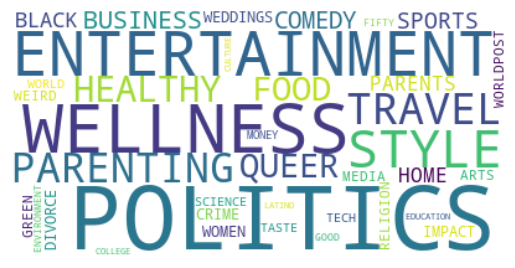

In [10]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

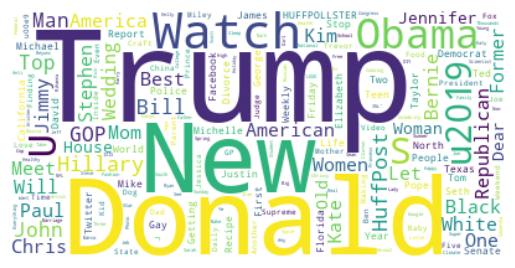

In [11]:
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Vectorization**

In [12]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SANTHOSHKUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [14]:
data['category'] = [re.sub(r'[^\w\s]', '', t) for t in data['category']]
data['short_description'] = [re.sub(r'[^\w\s]', '', t) for t in data['short_description']]

data['category'] = [t.lower() for t in data['category']]
data['short_description'] = [t.lower() for t in data['short_description']]

In [15]:
data["combined"] = data['category'] + '  ' + data['headline'] + ' ' + data['short_description']
data.drop(["short_description"],axis=1,inplace=True)
data.head()

,headline,category,combined
0,There Were 2 Mass Shootings In Texas Last Wee...,crime,crime There Were 2 Mass Shootings In Texa...
1,Will Smith Joins Diplo And Nicky Jam For The ...,entertainment,entertainment Will Smith Joins Diplo And ...
2,Hugh Grant Marries For The First Time At Age ...,entertainment,entertainment Hugh Grant Marries For The ...
3,Jim Carrey Blasts 'Castrato' Adam Schiff And ...,entertainment,entertainment Jim Carrey Blasts 'Castrato...
4,Julianna Margulies Uses Donald Trump Poop Bag...,entertainment,entertainment Julianna Margulies Uses Don...


## **CLASSIFICATION MODEL**

In [16]:
X=data["combined"]
T=data["category"]


Y=X[0:9999]
X_train_tf = tf_vectorizer.fit_transform(Y)
X_test_tf = tf_vectorizer.transform(X[10000:10500])
Z=T[0:9999]
Z1=T[10000:10500]


# **Naive Bayes**

In [17]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, Z)

MultinomialNB()

In [18]:
y_pred = naive_bayes_classifier.predict(X_test_tf)

In [19]:
y_pred

array([' politics  ', ' politics  ', ' politics  ', ' politics  ',
       ' politics  ', ' politics  ', ' entertainment  ', ' world news  ',
       ' comedy  ', ' entertainment  ', ' politics  ', ' politics  ',
       ' entertainment  ', ' politics  ', ' politics  ', ' politics  ',
       ' entertainment  ', ' politics  ', ' world news  ', ' politics  ',
       ' politics  ', ' latino voices  ', ' politics  ', ' politics  ',
       ' politics  ', ' politics  ', ' politics  ', ' entertainment  ',
       ' entertainment  ', ' politics  ', ' politics  ',
       ' queer voices  ', ' politics  ', ' politics  ', ' politics  ',
       ' politics  ', ' entertainment  ', ' politics  ', ' politics  ',
       ' politics  ', ' entertainment  ', ' entertainment  ',
       ' entertainment  ', ' entertainment  ', ' politics  ',
       ' politics  ', ' entertainment  ', ' politics  ',
       ' queer voices  ', ' entertainment  ', ' politics  ',
       ' queer voices  ', ' entertainment  ', ' politics 

In [20]:
score1 = metrics.accuracy_score(Z1, y_pred)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(Z1, y_pred))

print("confusion matrix:")
print(metrics.confusion_matrix(Z1, y_pred))

accuracy:   0.636
                   precision    recall  f1-score   support

  arts  culture         0.00      0.00      0.00         6
   black voices         0.83      0.42      0.56        12
       business         0.00      0.00      0.00        12
         comedy         1.00      0.41      0.58        32
          crime         1.00      0.14      0.25         7
      education         0.00      0.00      0.00         4
  entertainment         0.46      1.00      0.63        58
          green         0.00      0.00      0.00        13
 healthy living         0.00      0.00      0.00        11
         impact         0.00      0.00      0.00         8
  latino voices         1.00      0.12      0.22         8
          media         1.00      0.11      0.19        19
        parents         0.00      0.00      0.00        12
       politics         0.63      1.00      0.77       181
   queer voices         0.93      0.93      0.93        30
       religion         0.00      0.0

c:\Users\SANTHOSHKUMAR\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\SANTHOSHKUMAR\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\SANTHOSHKUMAR\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# **Support Vector Machine**

In [21]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')

# fitting x samples and y classes
clf.fit(X_train_tf, Z)

SVC(kernel='linear')

In [22]:
y_pred = clf.predict(X_test_tf)

In [23]:
score1 = metrics.accuracy_score(Z1, y_pred)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(Z1, y_pred))

print("confusion matrix:")
print(metrics.confusion_matrix(Z1, y_pred))


accuracy:   0.982
                   precision    recall  f1-score   support

  arts  culture         1.00      0.67      0.80         6
   black voices         0.92      1.00      0.96        12
       business         1.00      0.83      0.91        12
         comedy         1.00      1.00      1.00        32
          crime         0.88      1.00      0.93         7
      education         1.00      1.00      1.00         4
  entertainment         1.00      1.00      1.00        58
          green         1.00      1.00      1.00        13
 healthy living         1.00      0.91      0.95        11
         impact         1.00      1.00      1.00         8
  latino voices         1.00      1.00      1.00         8
          media         1.00      1.00      1.00        19
        parents         1.00      0.92      0.96        12
       politics         0.99      0.99      0.99       181
   queer voices         1.00      1.00      1.00        30
       religion         1.00      1.0

# **Decision Trees**

In [25]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'


In [26]:
dt = DecisionTreeClassifier()
dt.fit(X_train_tf, Z)
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = data.combined[0:22610], class_names=Z)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph = graphviz.Source(dot_data.getvalue())
graph.render("graph")
graph.view()

'graph.pdf'

## **Accuracy**

In [27]:
score1 = metrics.accuracy_score(Z1, y_pred)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(Z1, y_pred))

print("confusion matrix:")
print(metrics.confusion_matrix(Z1, y_pred))

accuracy:   0.982
                   precision    recall  f1-score   support

  arts  culture         1.00      0.67      0.80         6
   black voices         0.92      1.00      0.96        12
       business         1.00      0.83      0.91        12
         comedy         1.00      1.00      1.00        32
          crime         0.88      1.00      0.93         7
      education         1.00      1.00      1.00         4
  entertainment         1.00      1.00      1.00        58
          green         1.00      1.00      1.00        13
 healthy living         1.00      0.91      0.95        11
         impact         1.00      1.00      1.00         8
  latino voices         1.00      1.00      1.00         8
          media         1.00      1.00      1.00        19
        parents         1.00      0.92      0.96        12
       politics         0.99      0.99      0.99       181
   queer voices         1.00      1.00      1.00        30
       religion         1.00      1.0

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers

In [29]:
inputs = Input(shape=(20000,))
x = Embedding(input_dim=20000, output_dim=50)(inputs)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation='softmax')(x)
model = Sequential([
    layers.Dense(64, activation='relu', input_shape=(20000,)),
    layers.Dense(10, activation='softmax', input_shape=(20000,))
])

# model = Model(inputs=inputs, outputs=outputs)
model.add(Dense(41, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
tensorboard_callback = TensorBoard(log_dir="logs")

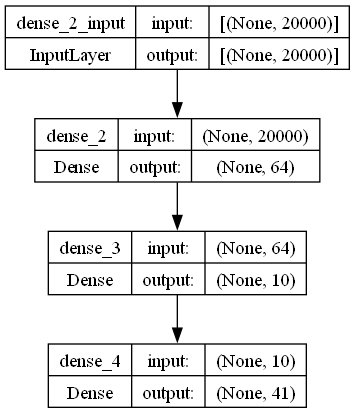

In [31]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [32]:
tf.saved_model.save(model, '/content/model1.pb')

INFO:tensorflow:Assets written to: /content/model1.pb\assets


INFO:tensorflow:Assets written to: /content/model1.pb\assets


In [34]:
import pydot
# dot = tf.keras.utils.model_to_dot(model)
# Create a networkx Graph object
G = nx.DiGraph()


In [35]:
# tfidf = TfidfVectorizer(stop_words="english")
# tfidf_matrix = tfidf.fit_transform(data["combined"])
# feature_names = tfidf.get_feature_names()

# Compute similarity matrix
cosine_sim = cosine_similarity(X_train_tf,X_train_tf)

# Get recommendations for a user
user_id = 123
user_history = [" The White House Says This Photo Shows Trump Working. People Aren\u2019t Buying It. authors", " Moderate Senators Cite Progress In Talks To End Government Shutdown authors"]
user_history_indices = data[data["headline"].isin(user_history)].index
similarity_scores=0
cc=0.50
for i in user_history_indices:
  similarity_scores+=cosine_sim[i]*cc
  cc/=2
# similarity_scores = cosine_sim[user_history_indices].sum(axis=0)
similar_articles_indices = similarity_scores.argsort()[::-1][:10]
similar_articles = data.iloc[similar_articles_indices]

In [36]:
similar_articles

,headline,category,combined
7172,Moderate Senators Cite Progress In Talks To E...,politics,politics Moderate Senators Cite Progress ...
8598,Top GOP Races To Watch In 2018 authors,politics,politics Top GOP Races To Watch In 2018 a...
2115,McCain Undergoes Surgery To Treat Intestinal ...,politics,politics McCain Undergoes Surgery To Trea...
2128,Republicans Are Scrambling To Save An Arizona...,politics,politics Republicans Are Scrambling To Sa...
7655,A Deconstruction Of The Alt-Right Movement au...,politics,politics A Deconstruction Of The Alt-Righ...
1007,2 Senators To Watch In The Fight Over Gina Ha...,politics,politics 2 Senators To Watch In The Fight...
7071,Senator Tammy Duckworth Makes Historic Pregna...,politics,politics Senator Tammy Duckworth Makes Hi...
1282,Lawmakers In Both Parties In Talks To Save Ho...,politics,politics Lawmakers In Both Parties In Tal...
7262,With A Shutdown Looming Government Agencies A...,politics,politics With A Shutdown Looming Governme...
3039,Foxconn In Choppy Waters Over Plan To Drain T...,politics,politics Foxconn In Choppy Waters Over Pl...


Real Time News Fetching

In [37]:
import requests
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.error import HTTPError
response = requests.get("https://newsapi.org/v2/top-headlines?country=in&apiKey=e9fc548f40394bc18d154b09abed1394")
data = json.loads(response.text)




articles = data.get('articles', [])
content = [article['content'] for article in articles if article.get('content')]
for i in content:
  print(i)
# print(content)

On 10 October (Tuesday), the Israel Defense Forces took international journalists to an Israeli border town, Kfar Aza which was one of the worst-hit areas when Hamas terrorists attacked Israel from t… [+4454 chars]
One of the greatest stars of Indian cinema, Amitabh Bachchan, is turning 81 on October 11, 2023. In his decades-spanning career, the celebrated actor has given us several iconic films. Additionally, … [+4197 chars]
Indias most picturesque villages
Hamas has held around 150 hostages since its ground incursion
Jerusalem: Israel said it recaptured Gaza border areas from Hamas terrorists as the war's death count passed 3,000 on Tuesday, the fourt… [+6813 chars]
Media caption, 'Putin hates Clinton' and other things the FBI learned about Russia
FBI director James Comey has confirmed for the first time that the FBI is investigating alleged Russian interferenc… [+5942 chars]
An act of showing solidarity for Palestine amid the recent clashes between Israel and Hamas, has come at a he

In [38]:
soup = BeautifulSoup(response.content, 'html.parser')
print(soup.prettify())

{"status":"ok","totalResults":38,"articles":[{"source":{"id":null,"name":"OpIndia"},"author":"OpIndia Staff","title":"Israel horror: Over 40 children killed and beheaded by Hamas terrorists, several victims reportedly burnt alive - OpIndia","description":"The media organisations that visited the Israeli border areas raided by Hamas terrorists found bodies of several babies, with many of their heads chopped off. | OpIndia News","url":"https://www.opindia.com/2023/10/israel-horror-over-40-children-killed-beheaded-by-hamas-terrorists-several-victims-burnt-alive/","urlToImage":"https://www.opindia.com/wp-content/uploads/2023/10/Israeli_massacre2.jpg","publishedAt":"2023-10-10T15:47:36Z","content":"On 10 October (Tuesday), the Israel Defense Forces took international journalists to an Israeli border town, Kfar Aza which was one of the worst-hit areas when Hamas terrorists attacked Israel from t… [+4454 chars]"},{"source":{"id":null,"name":"Hindustan Times"},"author":"HT Entertainment Desk",

In [39]:
h1=soup.h1
print(h1)
img=soup.img
print(img)
anchor=soup.a
print(anchor)
print(soup.script)
print(soup.find('div'))

None
None
None
None
None


In [40]:
soup.find_all('p')

[]

In [41]:
soup.find_all('sup', class_='reference')

[]

In [42]:
soup.find_all(id="footer-places-mobileview")

[]

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Preprocess the article content
content = [article['content'] for article in articles if article.get('content')]
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(content)

# Build a recommendation model
similarity_matrix = cosine_similarity(tfidf_matrix)

def recommend_articles(article_index, num_recommendations=5):
    # Get the indices of the most similar articles
    similar_indices = similarity_matrix[article_index].argsort()[:-num_recommendations-2:-1]
    # Get the titles of the most similar articles
    recommended_titles = [articles[i]['title'] for i in similar_indices]
    recommended_titles.pop(0)
    return recommended_titles
print("Title",end=" ")
print(articles[10]['title'])
print("Recommendations: \n")
recommendations = recommend_articles(10)
for title in recommendations:
    print(title)

Title Parineeti Chopra sports sindoor and pink choora as she returns to Mumbai. Watch - Hindustan Times
Recommendations: 

Stroke may cause 10 million deaths by 2050; what causes stroke; how to prevent - Hindustan Times
Amitabh Bachchan birthday: What Hollywood celebs have said about the star - Hindustan Times
Stranded for six days in Sikkim, tourist families recall trauma before rescue - Hindustan Times
Govt’s mental health helpline helped over 350,000 people | Mint - Mint
"India Must Intervene": Palestine Envoy To NDTV Amid Israel's Gaza Strike - NDTV


In [45]:
G = nx.Graph()

# Add nodes to the graph
for i in range(len(content)):
    article = articles[i]
    G.add_node(i, title=i)

# Add edges to the graph
for i in range(len(content)):
    for j in range(i+1, len(content)):
        similarity = similarity_matrix[i][j]
        if similarity >= 0.02:
            G.add_edge(i, j, weight=similarity)



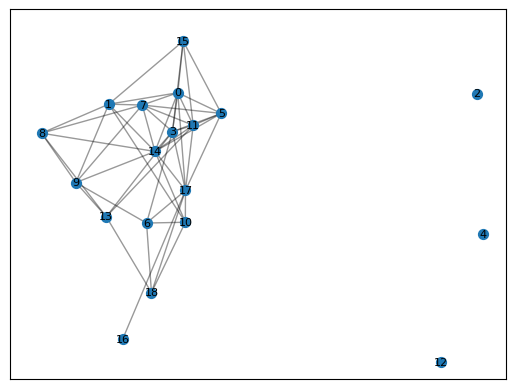

In [46]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'title'), font_size=8)
plt.show()